In [103]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, label_to_idx=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Create mapping from label string to integer index
        if label_to_idx is None:
            labels = sorted(self.df['id'].unique())
            self.label_to_idx = {label: idx for idx, label in enumerate(labels)}
        else:
            self.label_to_idx = label_to_idx

        # Map labels in dataframe to integers
        self.df['label_idx'] = self.df['id'].map(self.label_to_idx)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = f"{self.img_dir}/{row['filename']}"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Return image, class index, shiny flag
        return image, row['label_idx'], row['shiny']


In [104]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import random


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Setting Up Transforms
temp_tf = transforms.ToTensor()

temp_ds = ImageFolder("Training_Shiny/final/train", transform=temp_tf)
stats_loader = DataLoader(temp_ds, batch_size=32, shuffle=False)

mean = 0.0
std = 0.0
n_samples = 0

for data, _ in stats_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # flatten H*W
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

print(mean)
print(std)

#Loading Dataset
label_to_idx = None  # will auto-generate from training CSV

train_ds = PokemonDataset("Training_Shiny/final/train.csv", "Training_Shiny/final/train", transform=train_tf, label_to_idx=label_to_idx)
val_ds   = PokemonDataset("Training_Shiny/final/val.csv",   "Training_Shiny/final/val",   transform=val_tf,   label_to_idx=train_ds.label_to_idx)
test_ds  = PokemonDataset("Training_Shiny/final/test.csv",  "Training_Shiny/final/test",  transform=test_tf,  label_to_idx=train_ds.label_to_idx)


#Creating Dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=True)



tensor([0.8303, 0.8191, 0.7997])
tensor([0.2651, 0.2751, 0.2992])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1315472..0.6692764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1315472..0.6692764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1315472..0.6692764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1315472..0.6692764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1315472..0.6692764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1315472..0.6692764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.131547

torch.Size([64, 3, 96, 96])
tensor([14, 12, 28,  3, 25, 16, 28,  1, 29,  0,  4,  1,  0, 20, 10,  2, 23, 19,
         0, 25,  7,  9, 13, 20, 28, 18,  0, 28,  3, 17, 25, 20,  6,  1, 19, 22,
        20, 26,  9, 25,  8, 27, 21, 17,  2,  0,  3, 20, 26, 18, 22, 27,  2, 18,
        11, 18,  2, 18,  9,  4, 11, 12, 20, 25])


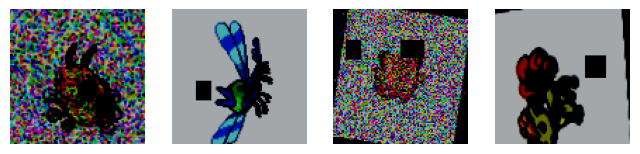

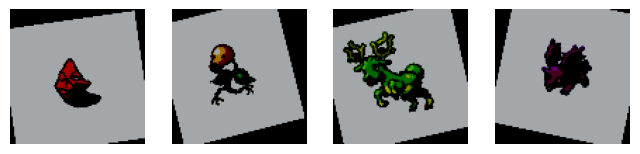

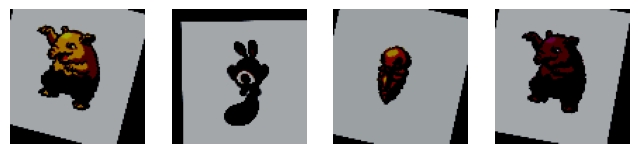

In [105]:
x_next_train, id_next_train, y_next_train = next(iter(train_loader))
x_next_val, id_next_val, y_next_val = next(iter(val_loader))
x_next_test, id_next_test, y_next_test = next(iter(test_loader))

print(x_next_train.shape)
print(id_next_train)

#Training
plt.figure(figsize=(8,4))
for i, idx in enumerate([1,2,3,4]):
    img = x_next_train[idx].permute(1,2,0)

    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')

#Validation
plt.figure(figsize=(8,4))
for i, idx in enumerate([1,2,3,4]):
    img = x_next_val[idx].permute(1,2,0)

    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')

#Testing
plt.figure(figsize=(8,4))
for i, idx in enumerate([1,2,3,4]):
    img = x_next_test[idx].permute(1,2,0)

    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis('off')

Building Multi-Modal Model

In [110]:
#Multi-Modal Model
import torchvision.models as models
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler


class ShinyCNN(nn.Module):
    def __init__(self, feature_dim = 256):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )


        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256, feature_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x
        

class ShinyModal(nn.Module):
    def __init__(self, num_species = 30, id_emb_dim = 32, img_feat_dim = 256, num_classes = 2):
        super().__init__()

        self.cnn = ShinyCNN(feature_dim=img_feat_dim)

        self.id_proj = nn.Embedding(num_species, id_emb_dim)

        fusion_dim = img_feat_dim + id_emb_dim

        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, 256), #concatenating features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self,image_data, id_data):
        image_features = self.cnn(image_data)
        id_features = self.id_proj(id_data)
        #concatenate features
        combined_features = torch.cat([image_features, id_features], dim = 1)
        
        output = self.fusion(combined_features)
        return output

In [114]:
#Transfer Learning - MobileNetV2
import torchvision.models as models
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

#Hyperparameters
lr = 1e-3
wt_decay = 1e-4
batch_size = 32

#Transfer Learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_Shiny = ShinyModal().to(device)
print(model_Shiny)

#creating Loss Function
entropy = nn.CrossEntropyLoss()

#Creating Optimizer
adam_opt = torch.optim.AdamW(model_Shiny.parameters(), lr = lr, weight_decay=wt_decay)

#LR_Scheduler
scheduler = lr_scheduler.CosineAnnealingLR(adam_opt, T_max=5)

ShinyModal(
  (cnn): ShinyCNN(
    (features): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
    )
    (head): Sequential(
      (0): AdaptiveAvgPool2d(output_size=(1, 1))
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
  )
  (id_proj): Embedding(30, 32)
  (fusion): Sequential(
    (0): Linear(in_features=28

In [ ]:
def train_loop(dataloader, model, loss_fn, opt, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0,0

    #Setting Model to Training Mode
    model.train()

    #Looping through dataloader
    for batch, (X,id,y) in enumerate(dataloader):
        #Computing Prediction and Loss
        X,id,y = X.to(device), id.to(device), y.to(device)

        y_pred = model(X, id)
        loss = loss_fn(y_pred, y)

        #Backdrop Section
        opt.zero_grad()
        loss.backward()
        opt.step()

        #Metric Calculations
        train_loss += loss.item() * X.size(0)
        train_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    #Averaging Loss and Accuracy
    train_loss /= size
    train_acc /= size

    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn, device):
    #Setting model to eval mode
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0,0

    #Looping through dataloader
    with torch.no_grad():
        for X,id,y in dataloader:
            X,id,y = X.to(device), id.to(device), y.to(device)
            y_pred = model(X, id)

            #Calculating Metric
            test_loss += loss_fn(y_pred,y).item() * X.size(0)
            test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    #Averaging Metrics
    test_loss /= size
    test_acc /= size

    return test_loss, test_acc

In [116]:
#Training
#Lists for training and validation
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epochs = 5 #Running for 10 epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    train_loss, train_acc = train_loop(train_loader, model_Shiny, entropy, adam_opt, device)
    val_loss, val_acc = test_loop(val_loader, model_Shiny, entropy, device)

    #Appending lists with loss and accuracy calculated per epoch
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    #Incrementing LR Scheduler
    before_lr = adam_opt.param_groups[0]['lr']
    scheduler.step()
    after_lr = adam_opt.param_groups[0]['lr']
    #Displaying Learning Rate per epoch
    print("Epoch %d: SGD lr %.4f -> %.4f" % (t, before_lr, after_lr))


    #Displaying losses and accuracies
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Validation  Loss: {val_loss:.4f}, Test  Acc: {val_acc*100:.2f}%\n")

print("Done!")

Epoch 1
-----------------------
Epoch 0: SGD lr 0.0010 -> 0.0009
Train Loss: 0.6990, Train Acc: 49.43%
Validation  Loss: 0.6940, Test  Acc: 50.00%

Epoch 2
-----------------------
Epoch 1: SGD lr 0.0009 -> 0.0007
Train Loss: 0.6808, Train Acc: 54.10%
Validation  Loss: 0.6116, Test  Acc: 65.50%

Epoch 3
-----------------------
Epoch 2: SGD lr 0.0007 -> 0.0003
Train Loss: 0.5176, Train Acc: 74.05%
Validation  Loss: 0.4583, Test  Acc: 76.67%

Epoch 4
-----------------------
Epoch 3: SGD lr 0.0003 -> 0.0001
Train Loss: 0.3447, Train Acc: 86.40%
Validation  Loss: 0.3361, Test  Acc: 85.17%

Epoch 5
-----------------------
Epoch 4: SGD lr 0.0001 -> 0.0000
Train Loss: 0.2752, Train Acc: 89.69%
Validation  Loss: 0.3171, Test  Acc: 87.17%

Done!


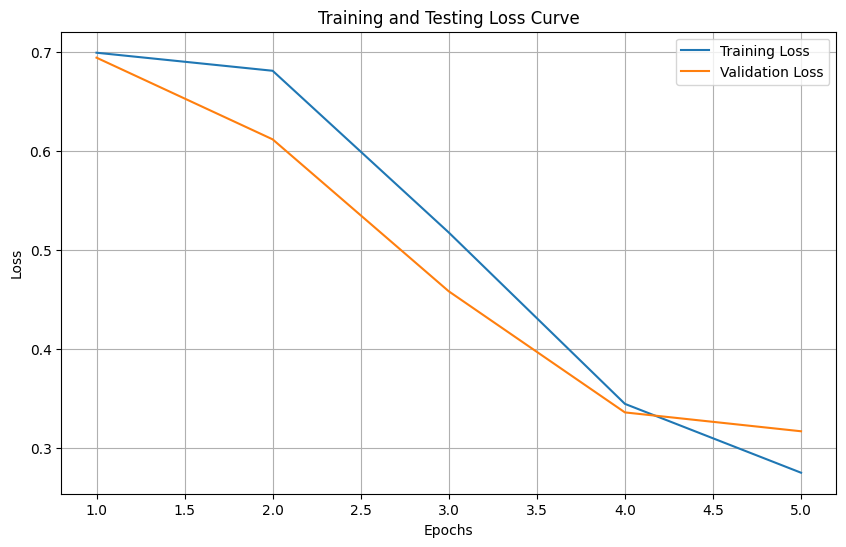

In [117]:
#Training and Validation Loss Curves

epoch_plot = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_plot, train_losses, label='Training Loss')
plt.plot(epoch_plot, val_losses, label='Validation Loss')
plt.title('Training and Testing Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

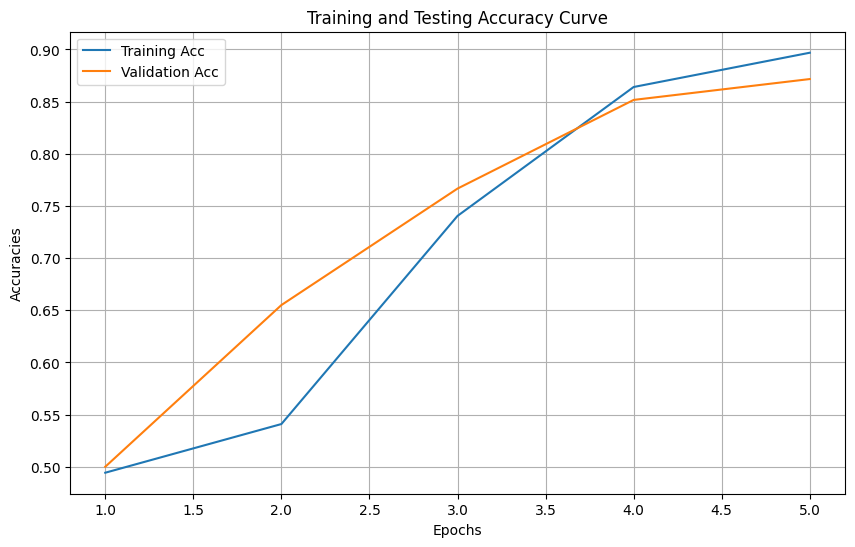

In [118]:
#Training and Validation Accuracy Curves

plt.figure(figsize=(10, 6))
plt.plot(epoch_plot, train_accs, label='Training Acc')
plt.plot(epoch_plot, val_accs, label='Validation Acc')
plt.title('Training and Testing Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.grid(True)
plt.show()

Evaluation Metrics Section

In [119]:
#Evaluating Model: accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

#Method to calculate Performance Metrics
def eval_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labs = []

    #Collecting Predictions and Labels
    with torch.no_grad(): #Turns off Gradient Tracking
        for X,id, y in dataloader:
            X,id, y = X.to(device), id.to(device), y.to(device)
            #Calculating Predictions
            y_pred = model(X, id)
            y_preds = y_pred.argmax(1)

            all_preds.extend(y_preds.cpu().tolist())
            all_labs.extend(y.cpu().tolist())
    
    #Creating Confusion Matrix
    
    cm = confusion_matrix(all_labs, all_preds)
    np.set_printoptions(linewidth=200)
    print(cm)


    #Calculating Performance Metrics
    acc = accuracy_score(all_labs, all_preds)
    precision = precision_score(all_labs, all_preds, average='macro')
    recall = recall_score(all_labs, all_preds, average = 'macro')
    f1 = f1_score(all_labs, all_preds, average='macro')

    return acc, precision, recall, f1, np.array(all_preds), np.array(all_labs), cm

In [120]:
test_acc, test_prec, test_recall, test_f1, y_pred, y_true, cm = eval_model(model_Shiny, test_loader, device)

print("Accuracy :", test_acc)
print("Precision:", test_prec)
print("Recall   :", test_recall)
print("F1 Score :", test_f1)
cm_norm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
print(cm_norm)

[[487 113]
 [ 62 538]]
Accuracy : 0.8541666666666666
Precision: 0.8567441431005682
Recall   : 0.8541666666666666
F1 Score : 0.8539027785604415
[[0.81166667 0.18833333]
 [0.10333333 0.89666667]]


Saving the Model

In [121]:
#This saves the model to the Model folder
path = "Model/shiny_classifier.pt"
torch.save(model_Shiny, path)
